In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the generation data
gen_df = pd.read_csv('Plant_2_Generation_Data.csv', sep=',')
print("Columns in generation data:", gen_df.columns.tolist())

Columns in generation data: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']


In [3]:
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])

In [4]:
# drop SOURCE_KEY column
gen_df = gen_df[['DATE_TIME', 'PLANT_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]

In [5]:
# Read the weather sensor data
weather_df = pd.read_csv('Plant_2_Weather_Sensor_Data.csv', sep=',')
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])
weather_df = weather_df[['DATE_TIME', 'PLANT_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

#### Merge the two datasets on DATE_TIME and PLANT_ID.

In [6]:
merged_df = pd.merge_asof(
    gen_df.sort_values('DATE_TIME'),
    weather_df.sort_values('DATE_TIME'),
    on='DATE_TIME',
    by='PLANT_ID',
    direction='nearest',  
    tolerance=pd.Timedelta('15min')  
)

In [7]:
# Check the merged dataset
print(merged_df.head())
print(merged_df.info())

   DATE_TIME  PLANT_ID  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15   4136001       0.0       0.0  9425.000000    2429011.0   
1 2020-05-15   4136001       0.0       0.0     0.000000  209143593.0   
2 2020-05-15   4136001       0.0       0.0  9166.000000  106656621.0   
3 2020-05-15   4136001       0.0       0.0     0.000000    2211962.0   
4 2020-05-15   4136001       0.0       0.0   280.214286  120964108.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            27.004764           25.060789          0.0  
1            27.004764           25.060789          0.0  
2            27.004764           25.060789          0.0  
3            27.004764           25.060789          0.0  
4            27.004764           25.060789          0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----       

In [8]:
# DATE_TIME is a datetime object (if not already)
merged_df['DATE_TIME'] = pd.to_datetime(merged_df['DATE_TIME'])

In [9]:
# Set DATE_TIME as the index
merged_df.set_index('DATE_TIME', inplace=True)

In [10]:
# use time-based interpolation
merged_df.interpolate(method='time', inplace=True)
merged_df.fillna(method='bfill', inplace=True)

C:\Users\Daiyaan\AppData\Local\Temp\ipykernel_15852\347893614.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)


### Exploratory Data Analysis (EDA) and Feature Engineering

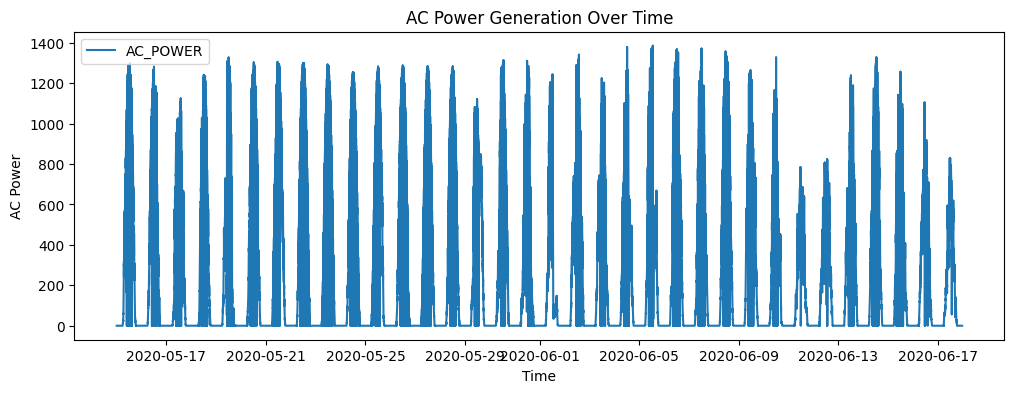

In [11]:
# Plot AC_POWER over time
plt.figure(figsize=(12, 4))
plt.plot(merged_df.index, merged_df['AC_POWER'], label='AC_POWER')
plt.xlabel('Time')
plt.ylabel('AC Power')
plt.title('AC Power Generation Over Time')
plt.legend()
plt.show()

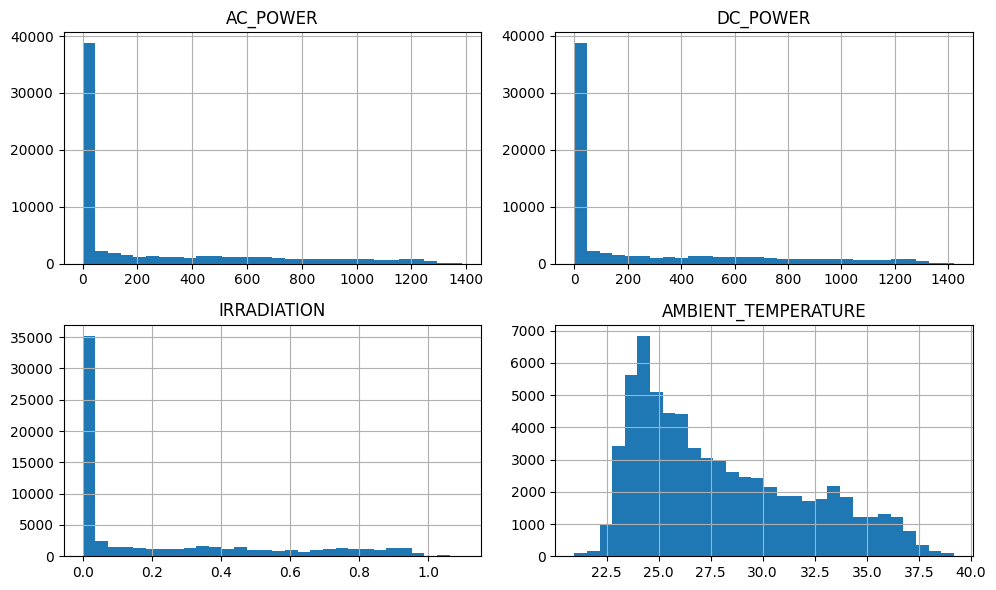

In [12]:
# Plot histograms of key features
merged_df[['AC_POWER', 'DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE']].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

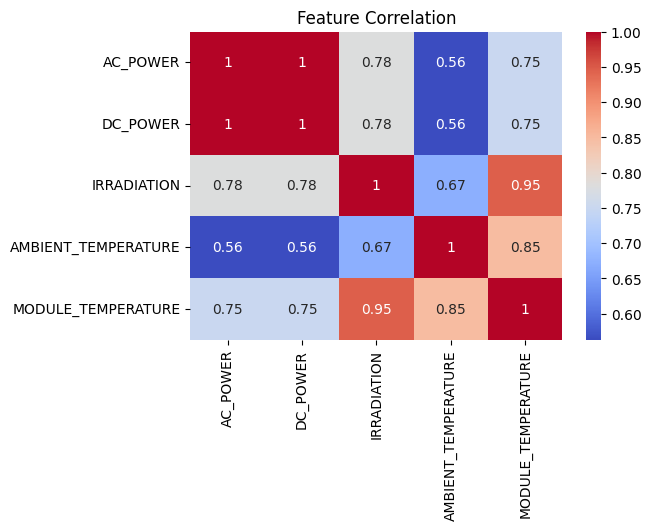

In [13]:
# Create a correlation heatmap
plt.figure(figsize=(6,4))
corr = merged_df[['AC_POWER', 'DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

### Feature Engineering

In [14]:
print(merged_df.index)

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               ...
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=67698, freq=None)


In [15]:
# Create time-based features
merged_df['hour'] = merged_df.index.hour
merged_df['day_of_week'] = merged_df.index.dayofweek
merged_df['month'] = merged_df.index.month

In [16]:
# create a lag feature for AC_POWER
merged_df['AC_POWER_lag1'] = merged_df['AC_POWER'].shift(1)

In [17]:
# Drop initial row(s) with NaN values from lag feature
merged_df.dropna(inplace=True)

### Feature Analysis

In [33]:
from sklearn.model_selection import train_test_split

In [19]:
# # Define target and features
# target = 'AC_POWER'
# features = ['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 
#             'MODULE_TEMPERATURE', 'hour', 'day_of_week', 'month', 'AC_POWER_lag1']

In [20]:
# X = merged_df[features]
# y = merged_df[target]

In [34]:
# Split into training and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [35]:
# for hyperparameter tuning:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [36]:
# Define hyperparameter for each model.

param_grid_lr = {}  # No tuning for LinearRegression

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [37]:
# models and their parameter grids in a dictionary.
models = {
    "Linear Regression": (LinearRegression(), param_grid_lr),
    "Random Forest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), param_grid_gb),
    "XGBoost": (xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb)
}

results = {}
best_model = None
best_mae = float("inf")
best_model_name = None

In [ ]:
# # Train an initial XGBoost model
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
# xgb_model.fit(X_train, y_train)

In [38]:
# Loop each model, perform GridSearchCV, and evaluate performance.
for name, (model, grid) in models.items():
    print("Tuning model:", name)
    # use GridSearchCV.
    if grid:  
        grid_search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        cv_score = -grid_search.best_score_
        print(f"Best params for {name}: {best_params}")
    else:
        # LinearRegression model without hyperparameter, just fit the model.
        model.fit(X_train, y_train)
        best_estimator = model
        best_params = {}
        preds = best_estimator.predict(X_train)
        cv_score = mean_absolute_error(y_train, preds)
        print(f"{name} training MAE: {cv_score:.2f}")
        
    # Evaluate the tuned model on the test set.
    y_pred = best_estimator.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    
    results[name] = {
        "best_estimator": best_estimator,
        "best_params": best_params,
        "cv_score": cv_score,
        "test_mae": test_mae,
        "test_mse": test_mse
    }
    print(f"{name} Test MAE: {test_mae:.2f}, Test MSE: {test_mse:.2f}\n")
    
    # best performing model based on test MAE.
    if test_mae < best_mae:
        best_mae = test_mae
        best_model = best_estimator
        best_model_name = name

Tuning model: Linear Regression
Linear Regression training MAE: 0.60
Linear Regression Test MAE: 0.57, Test MSE: 0.87

Tuning model: Random Forest
Best params for Random Forest: {'max_depth': None, 'n_estimators': 100}
Random Forest Test MAE: 0.11, Test MSE: 0.31

Tuning model: Gradient Boosting
Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Gradient Boosting Test MAE: 0.13, Test MSE: 0.30

Tuning model: XGBoost
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Test MAE: 0.64, Test MSE: 1.38



In [40]:
results_df = pd.DataFrame({name: {"CV MAE": np.round(info["cv_score"], 2),
                                  "Test MAE": np.round(info["test_mae"], 2),
                                  "Test MSE": np.round(info["test_mse"], 2)}
                            for name, info in results.items()}).T
print(results_df)

print(f"\nBest model based on Test MAE: {best_model_name} with a Test MAE of {best_mae:.2f}")

                   CV MAE  Test MAE  Test MSE
Linear Regression    0.60      0.57      0.87
Random Forest        0.15      0.11      0.31
Gradient Boosting    0.15      0.13      0.30
XGBoost              0.72      0.64      1.38

Best model based on Test MAE: Random Forest with a Test MAE of 0.11


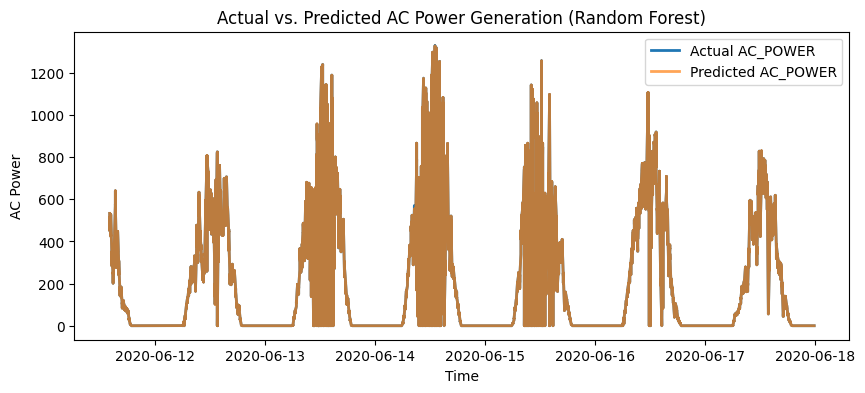

In [43]:
# Plot actual vs. predicted values for the best model.
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label='Actual AC_POWER', lw=2)
plt.plot(y_test.index, best_model.predict(X_test), label='Predicted AC_POWER', lw=2, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('AC Power')
plt.title(f"Actual vs. Predicted AC Power Generation ({best_model_name})")
plt.legend()
plt.show()